In [13]:
import numpy as np 
from sklearn.model_selection import train_test_split
import utils_config
import tensorflow as tf

from matplotlib import pyplot as plt
import larq as lq

In [14]:
np.random.seed(2021)

## Load Data

In [15]:
np_grid_data = np.load(r'_np_griddata.npy')
np_init_path = np.load(r'_np_initpath_nzp.npy')
np_opt_path = np.load(r'_np_optpath_nzp.npy')

In [16]:
np_grid_data = np_grid_data.astype('float32')/127.0
np_grid_data = np.reshape(np_grid_data,(np_grid_data.shape[0],np_grid_data.shape[1],np_grid_data.shape[1],1))
print(np_grid_data.max())
print("Shape of grid data:",np.shape(np_grid_data))
print("Shape of init path:",np.shape(np_init_path))
print("Shape of opt path:",np.shape(np_opt_path))

#plt.matshow(np_grid_data[0])

1.0
Shape of grid data: (227, 1536, 1536, 1)
Shape of init path: (227, 25, 2)
Shape of opt path: (227, 25, 2)


## Check Data balance 

In [17]:
# Check Data Balance
count=0

for i in range(len(np_opt_path)):
    if np.array_equiv(np_opt_path[i],np_init_path[i]):
        count +=1

print("Paths that are similar: {}, which is {} of total data".format(count,(count/len(np_init_path))))
print("Paths that are dissimalar: {},which is {} of total data".format((len(np_init_path)-count),((len(np_init_path)-count)/len(np_init_path))))

Paths that are similar: 207, which is 0.9118942731277533 of total data
Paths that are dissimalar: 20,which is 0.0881057268722467 of total data


## Build Data set

In [18]:
# Split dataset
train_grid,test_grid,train_init_path,test_init_path,train_opt_path,test_opt_path = train_test_split(np_grid_data,np_init_path,np_opt_path,random_state=np.random.randint(1),test_size=0.25)

In [19]:
'''print sizes and shapes of testing and training data'''

print("Shape of training grid data:",np.shape(train_grid))
print("Shape of training init path:",np.shape(train_init_path))
print("Shape of training opt path:",np.shape(train_opt_path))
print("-----------------------------------------------------")
print("Shape of testing grid data:",np.shape(test_grid))
print("Shape of testing init path:",np.shape(test_init_path))
print("Shape of testing opt path:",np.shape(test_opt_path))

Shape of training grid data: (170, 1536, 1536, 1)
Shape of training init path: (170, 25, 2)
Shape of training opt path: (170, 25, 2)
-----------------------------------------------------
Shape of testing grid data: (57, 1536, 1536, 1)
Shape of testing init path: (57, 25, 2)
Shape of testing opt path: (57, 25, 2)


In [20]:
def parse_func(input_data,optimized_path):
    
    '''    
    image_string = tf.io.read_file(filename)
    
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
   
    image = tf.image.resize(image_decoded, size=(util_constants.IMG_SIZE_VGG[0],util_constants.IMG_SIZE_VGG[1]))
    
    # add random noise to image
    noise = tf.random.normal(image.shape,0,3)
    
    image = image + noise
    
    image = preprocess_input(image)
    '''
    grid_data = input_data[0]
    
    init_path = input_data[1]
    
    grid_data = tf.cast(grid_data,tf.float16)
    grid_data = grid_data/tf.norm(grid_data)
    
    modified_input = (grid_data,init_path)
    return modified_input,optimized_path


AUTOTUNE = tf.data.experimental.AUTOTUNE

def build_dataset(grid,init_path,opt_path,data_set_type):
    
    ds = tf.data.Dataset.from_tensor_slices(((grid,init_path),opt_path))
    
    if data_set_type=='train':
        p_var = data_set_type
        print("####### Buildling {} data set..... ########".format(p_var))
        ds = ds.shuffle(utils_config.N_SHUFFLE_BUFFER)
        ds = ds.cache()
        ds = ds.map(parse_func, num_parallel_calls = AUTOTUNE)
      
    if not data_set_type=='train':
        print("Buildling {} data set".format(data_set_type))
        ds = ds.cache()
        #ds = ds.map(parse_func, AUTOTUNE)
    
    ds = ds.batch(utils_config.H_BATCH_SIZE,drop_remainder=True).prefetch(AUTOTUNE)
    
    print(ds.element_spec)
    
    return ds



In [21]:
ds_train = build_dataset(train_grid,train_init_path,train_opt_path,'train')
ds_test = build_dataset(test_grid,test_init_path,test_opt_path,'test')

####### Buildling train data set..... ########
((TensorSpec(shape=(16, 1536, 1536, 1), dtype=tf.float16, name=None), TensorSpec(shape=(16, 25, 2), dtype=tf.float64, name=None)), TensorSpec(shape=(16, 25, 2), dtype=tf.float64, name=None))
Buildling test data set
((TensorSpec(shape=(16, 1536, 1536, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 25, 2), dtype=tf.float64, name=None)), TensorSpec(shape=(16, 25, 2), dtype=tf.float64, name=None))


In [22]:
#check the tensorflow dataset   

#next(iter(ds_train))
for (input_data,output_data) in ds_train.take(1):
    np_one_grid = input_data[0].numpy()
    np_one_grid = np_one_grid[0]
    print((np_one_grid.max()))
    
    #(plt.matshow(input_data[0].numpy()[0]))
#print(plt.matshow(np.reshape(np_one_grid,(1536,1536))))

0.0079


In [48]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow tensor
    :param y_p red: TensorFlow tensor of the same shape as y_true
    :return: float
    """
    #original euclidean distance loss =  K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    loss = K.mean(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)))
    return loss

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

def nn():

    # define two sets of inputs
    input_A = layers.Input(shape=(1536,1536,1))
    input_B = layers.Input(shape=(25,2))

    #branch 1
    #x_B = lq.layers.QuantConv1D(2,kernel_size=3,kernel_quantizer="ste_sign", kernel_constraint="weight_clip", use_bias=False)(input_B)

    reshape_input_B = layers.Reshape((50,))(input_B)

    #CNN - branch2
    x_A = lq.layers.QuantConv2D(16,kernel_size=(7,7),strides=2, use_bias=False,**kwargs)(input_A)
    
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)
    x_A = layers.BatchNormalization(scale=False)(x_A)

    x_A = lq.layers.QuantConv2D(32,kernel_size=5,strides=2, use_bias=False,**kwargs)(x_A)
    
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(4,4))(x_A)
    x_A = layers.BatchNormalization(scale=False)(x_A)
    
    x_A = lq.layers.QuantConv2D(64,kernel_size=3,strides=2, use_bias=False,**kwargs)(x_A)
    
    x_A = layers.ReLU()(x_A)
    x_A = layers.AvgPool2D(pool_size=(2,2))(x_A)
    x_A = layers.BatchNormalization(scale=False)(x_A)

    #x_A = layers.Conv2D(filters=10,kernel_size=(1,1))(x_A)

    x_A = layers.Flatten()(x_A)
    
    #concatenate feature
    concat_feat = layers.concatenate([x_A, reshape_input_B])

    #concat_feat = layers.Lambda(lambda x: tf.expand_dims(x, -1))(concat_feat)

    #FC
    #output = layers.Convolution1D(50,kernel_size=3,padding='valid',activation='relu')(concat_feat)
    
    output = lq.layers.QuantDense(50, activation='linear', use_bias=False,**kwargs)(concat_feat)

    output = layers.Dropout(0.6)(output)
    
    output = lq.layers.QuantDense(50, activation='linear', use_bias=False,**kwargs)(output)
    
    
    output = layers.Reshape((25,2))(output)
    

    nn_fun = keras.models.Model(inputs = [input_A, input_B], outputs= output)
    
    return nn_fun
    

In [49]:
pp_model = nn()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
pp_model.compile(optimizer=opt,loss=euclidean_distance_loss, metrics='accuracy')

In [50]:
pp_model.summary()
lq.models.summary(pp_model)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1536, 1536,  0                                            
__________________________________________________________________________________________________
quant_conv2d_16 (QuantConv2D)   (None, 765, 765, 16) 784         input_17[0][0]                   
__________________________________________________________________________________________________
re_lu_15 (ReLU)                 (None, 765, 765, 16) 0           quant_conv2d_16[0][0]            
__________________________________________________________________________________________________
average_pooling2d_15 (AveragePo (None, 191, 191, 16) 0           re_lu_15[0][0]                   
____________________________________________________________________________________________

In [51]:
history = pp_model.fit(ds_train,epochs=100,validation_data=ds_test)

Epoch 1/100
10/10 [==============================] - 45s 4s/step - loss: 221.5607 - accuracy: 0.4889 - val_loss: 70.2465 - val_accuracy: 0.5950
Epoch 2/100
10/10 [==============================] - 46s 5s/step - loss: 152.0527 - accuracy: 0.5256 - val_loss: 65.7717 - val_accuracy: 0.3725
Epoch 3/100
10/10 [==============================] - 47s 5s/step - loss: 211.6268 - accuracy: 0.5289 - val_loss: 78.7158 - val_accuracy: 0.8500
Epoch 4/100
10/10 [==============================] - 48s 5s/step - loss: 132.3183 - accuracy: 0.5821 - val_loss: 84.4456 - val_accuracy: 0.5867
Epoch 5/100
10/10 [==============================] - 50s 5s/step - loss: 96.1481 - accuracy: 0.5524 - val_loss: 115.5015 - val_accuracy: 0.4400
Epoch 6/100
10/10 [==============================] - 53s 5s/step - loss: 102.4750 - accuracy: 0.5811 - val_loss: 93.1889 - val_accuracy: 0.9200
Epoch 7/100
10/10 [==============================] - 51s 5s/step - loss: 70.5922 - accuracy: 0.6672 - val_loss: 56.4898 - val_accuracy: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


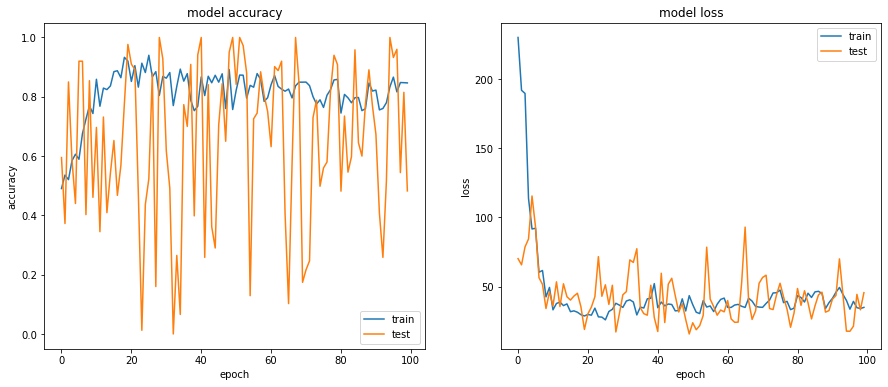

In [59]:
# list all data in history

plt.figure(figsize=(15, 6))

print(history.history.keys())
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
#plt.show()

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [52]:
predictions = pp_model.predict((test_grid,test_init_path))
print((predictions))

[[[-10.503896   -0.564249 ]
  [  6.0991445   5.9849634]
  [ -7.9215612 -16.694752 ]
  ...
  [-26.71185    -8.428318 ]
  [ -2.9553936   9.171863 ]
  [-15.32201   -27.67335  ]]

 [[-10.503896   -0.564249 ]
  [  6.0991445   5.9849634]
  [ -7.9215612 -16.694752 ]
  ...
  [-26.71185    -8.428318 ]
  [ -2.9553936   9.171863 ]
  [-15.32201   -27.67335  ]]

 [[ -7.4626575  -2.0356126]
  [  9.820963    5.1516957]
  [ -5.359667  -16.83983  ]
  ...
  [-25.151031   -7.333741 ]
  [ -1.4335134   8.844621 ]
  [-14.484293  -26.951653 ]]

 ...

 [[-12.412114    1.6165586]
  [  4.6788454   7.44064  ]
  [ -9.425728  -17.54176  ]
  ...
  [-27.334652   -9.271521 ]
  [ -3.1407926   9.043286 ]
  [-15.856079  -28.263632 ]]

 [[ -9.531599   -1.1626925]
  [  7.2510967   5.679312 ]
  [ -7.148549  -16.818724 ]
  ...
  [-26.134205   -8.047977 ]
  [ -2.4633262   9.096263 ]
  [-14.996502  -27.381254 ]]

 [[-10.503896   -0.5642484]
  [  6.0991464   5.9849668]
  [ -7.9215612 -16.694754 ]
  ...
  [-26.71185    -8.42831

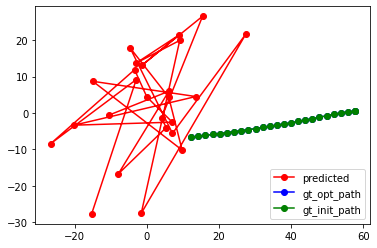

In [58]:
test_idx = 11

plt.plot(predictions[test_idx,:,0],predictions[test_idx,:,1],'o-', color='red')
plt.plot(test_opt_path[test_idx,:,0],test_opt_path[test_idx,:,1],'o-', color='blue')
plt.plot(test_init_path[test_idx,:,0],test_init_path[test_idx,:,1],'o-', color='green')
plt.legend(['predicted', 'gt_opt_path', 'gt_init_path'], loc='lower right')
plt.show()